In [2]:
import pandas as pd
#pd.set_option('display.max_columns',100) # Displaying max columns present in the dataframe
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore') # remove warnings from the notebook

import os
import glob
import ntpath

In [ ]:
# import wget 
# wget.download('https://myleott.com/op_spam_v1.4.zip')

In [ ]:
# import zipfile
# with zipfile.ZipFile('op_spam_v1.4.zip', 'r') as z:
#     z.extractall()

## Data Parsing

In [3]:
reg = '**/*.txt'

path = 'op_spam_v1.4/positive_polarity/'
filename= list()
reviews= list()
files = [i for i in glob.glob(path + reg,recursive = True)]
for file in files:
    with open(file, 'r') as f:
        filename.append(ntpath.basename(file))
        reviews.append(f.read())
positive_df= pd.DataFrame({'filename': filename, 'review': reviews})

#################################

path = 'op_spam_v1.4/negative_polarity/'
files = [f for f in glob.glob(path + reg, recursive=True)]
filename= list()
reviews= list()
for file in files:
    with open(file, 'r') as f:
        filename.append(ntpath.basename(file))
        reviews.append(f.read())
negative_df= pd.DataFrame({'filename': filename, 'review': reviews})

## Data Preparation

In [4]:
positive_df['polarity'] = 'positive'
negative_df['polarity'] = 'negative'

In [5]:
reg = r'_(.*)_'

negative_df['hotel'] = negative_df.filename.str.extract(reg)
positive_df['hotel'] = positive_df.filename.str.extract(reg)

positive_df['label'] = positive_df.filename.apply(lambda x  : 'true' if x[0] == 't' else 'deceptive' )
negative_df['label'] = negative_df.filename.apply(lambda x  : 'true' if x[0] == 't' else 'deceptive' )

In [6]:
df = pd.concat([positive_df, negative_df], ignore_index=True)

In [7]:
df.drop('filename', axis = 1, inplace = True)

## EDA

In [8]:
df.groupby(['polarity', 'label']).agg({'review' :'count'})

review
polarity label            
negative deceptive     400
         true          400
positive deceptive     400
         true          400

### Comparing word count in True and Deceptive reviews

In [9]:
import spacy
pipeline = spacy.load('en_core_web_md')

In [10]:
df['spacy'] =  df.review.str.lower().apply( pipeline )

In [11]:
df['word_count'] = df.spacy.apply(lambda x : len( list( x)))

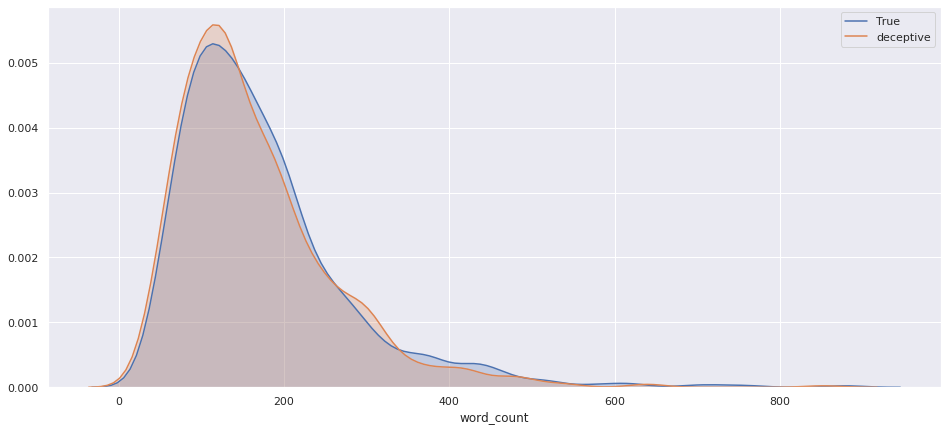

In [12]:
sns.set()
ax, fig = plt.subplots(figsize = (16, 7))

sns.distplot( df[df['label'] == 'true'].word_count,
             hist=False,
             kde_kws= {'shade': True, 'linewidth': 1.5},
             label = 'True')
sns.distplot( df[df['label'] == 'deceptive'].word_count, 
             kde_kws= {'shade': True, 'linewidth': 1.5},
             hist=False,
             label = 'deceptive')

### Comparing punctuation counts in True and deceptive review

In [13]:
import string

In [14]:
%%time
count = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))
punc= list(set(string.punctuation))

df['punc_count']=  df.review.apply(lambda x : count(x, punc))

CPU times: user 829 ms, sys: 15 µs, total: 829 ms
Wall time: 828 ms


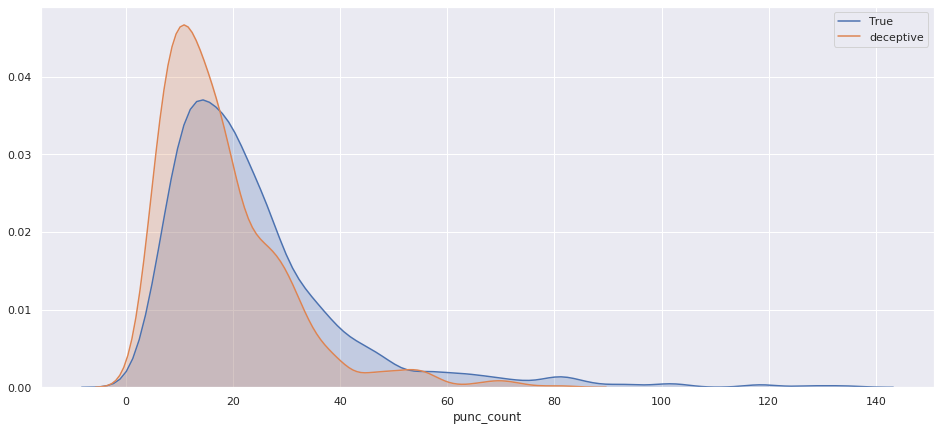

In [15]:
ax, fig = plt.subplots(figsize = (16, 7))

sns.distplot( df[df['label'] == 'true'].punc_count,
             hist=False,
             kde_kws= {'shade': True, 'linewidth': 1.5},
             label = 'True')
sns.distplot( df[df['label'] == 'deceptive'].punc_count, 
             kde_kws= {'shade': True, 'linewidth': 1.5},
             hist=False,
             label = 'deceptive')

### Comparing count of people citing hotel name in reviews

In [16]:
%%time
df['hotel_name_count']= df.apply(lambda x: str(x.review).lower().count(str(x.hotel)), axis = 1)

CPU times: user 84.5 ms, sys: 7.86 ms, total: 92.4 ms
Wall time: 202 ms


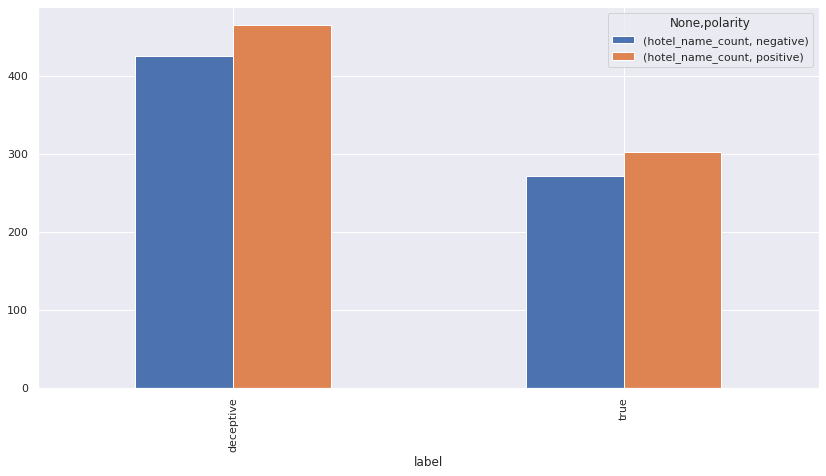

In [17]:
df.groupby(['label', 'polarity']).agg({'hotel_name_count':'sum'}).unstack().plot(kind = 'bar', figsize = (14, 7))

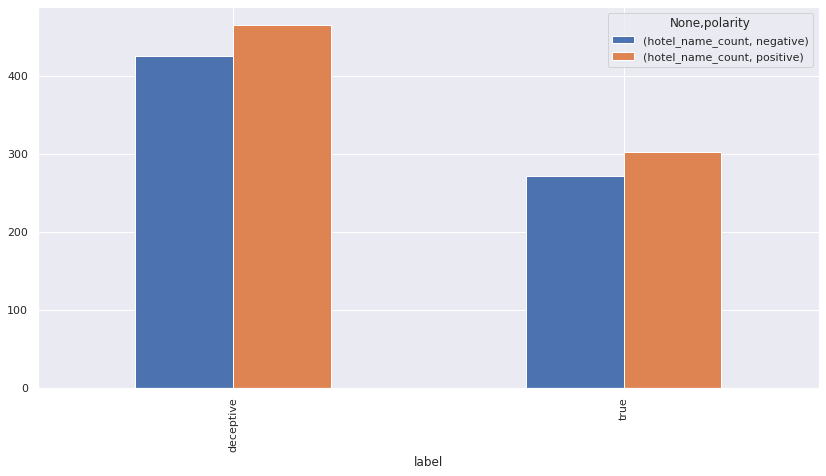

In [18]:
df.groupby(['label', 'polarity']).agg({'hotel_name_count':'sum'}).unstack().plot(kind = 'bar', 
                                                                                 figsize = (14, 7))

## Comparing Number of Unique words in reviews¶

In [19]:
df['unique_word_count']= df['spacy'].apply(lambda x: len(set(list(x))))

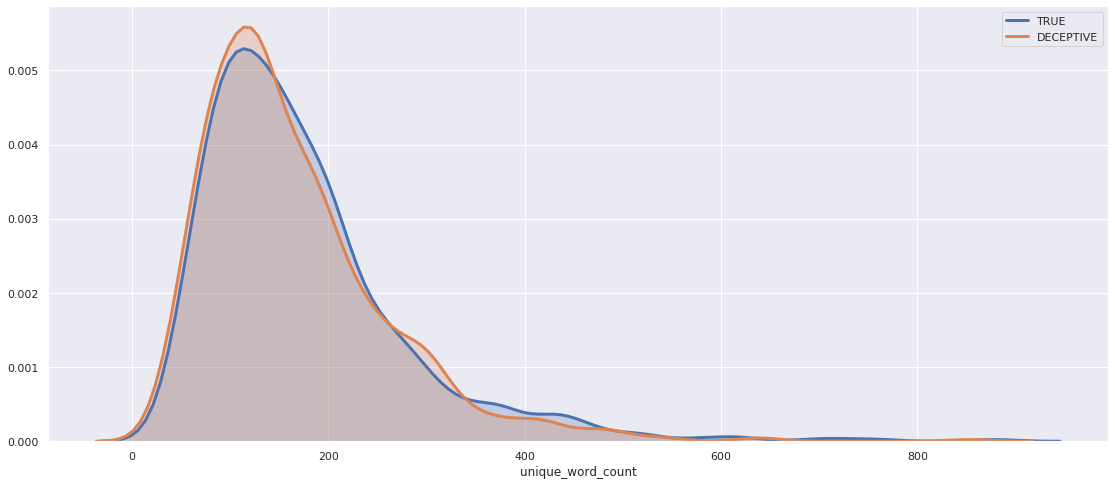

In [20]:
sns.set()
fig = plt.figure(figsize=(19, 8))
sns.distplot(df.loc[df.label== 'true', 'unique_word_count'], hist = False, kde = True, 
             kde_kws = {'shade': True, 'linewidth': 3}, 
             label= 'TRUE')
sns.distplot(df.loc[df.label== 'deceptive', 'unique_word_count'], hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
             label= 'DECEPTIVE');

### Comparing Stop Words

In [23]:
import string
count = lambda l1, l2: len(list(filter(lambda c: c in l2, l1)))
stop= list(pipeline.Defaults.stop_words)

df['stop_count']= df.review.apply(lambda x: count(x, stop))

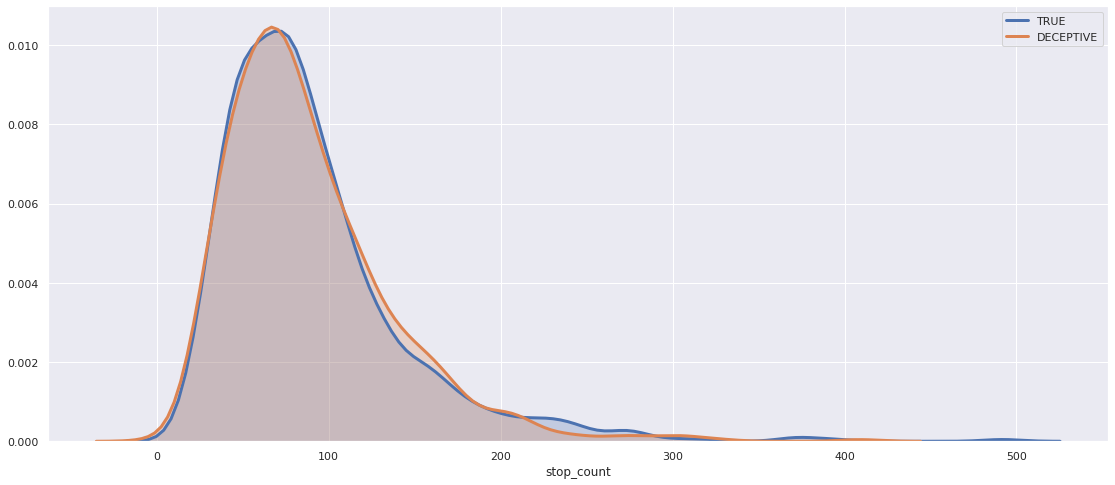

In [24]:
sns.set()

fig = plt.figure(figsize=(19, 8))
sns.distplot(df.loc[df.label== 'true', 'stop_count'], hist = False, kde = True, 
             kde_kws = {'shade': True, 'linewidth': 3}, 
             label= 'TRUE')
sns.distplot(df.loc[df.label== 'deceptive', 'stop_count'], hist = False, kde = True,
             kde_kws = {'shade': True, 'linewidth': 3}, 
             label= 'DECEPTIVE');

## Comparing POS tags in reviews

In [26]:
from collections import Counter
def pos_tag_count(df):
    
    # Create to empty lists in which we will store the list of POS Tags
    
    dec_pos_tags= list()
    true_pos_tags= list()
    # Iterate over Each Spacy Document Object
    
    for doc in df[df.label == 'true'].spacy:
        TAG_count = doc.count_by(spacy.attrs.TAG)
        true_dict = dict()
        
        # Spacy Returns a dictionary object with Hash Value of Pos and Counts
        # After every Iteration Update the POS Tag distioanry
        
        for key,value in sorted(TAG_count.items()):
            true_dict.update({ doc.vocab[key].text : value})
            
        # After updating the dict append it to the list we created at the very beiginning
        
        true_pos_tags.append(true_dict)
    
    # Then just follow the same above steps for the deceptive reviews as well  
    for doc in df[df.label == 'deceptive'].spacy:
        TAG_count = doc.count_by(spacy.attrs.TAG)
        dec_dict = dict()
        for key,value in sorted(TAG_count.items()):
            dec_dict.update({ doc.vocab[key].text : value})
        dec_pos_tags.append(dec_dict)
    
    '''    
    NoW the above returns a count object for each review in True and Deceptive we need to add them up
    for whole DataFrame using a counter object
    '''
    true_tag_count = Counter()
    for i in range(0,len(true_pos_tags)):
        true_tag_count = true_tag_count + Counter(true_pos_tags[i])
    dec_tag_count = Counter()
    for i in range(0,len(dec_pos_tags)):
        dec_tag_count = dec_tag_count + Counter(dec_pos_tags[i])
    true_tag_count = dict(true_tag_count)
    dec_tag_count = dict(dec_tag_count)
    
    ## Now Create a DataFrame for True Reviews with POS Tags and Counts
    true_pos = pd.DataFrame()
    true_pos['tag'] = true_tag_count.keys()
    true_pos['true_cnt'] = true_tag_count.values()
    
    ## Now Create a DataFrame for Deceptive Reviews with POS Tags and Counts
    dec_pos = pd.DataFrame()
    dec_pos['tag'] = dec_tag_count.keys()
    dec_pos['dec_cnt'] = dec_tag_count.values()
    
    # Merge these two DataFrames on Tag name
    reviews_tags = true_pos.merge(dec_pos, on='tag', how='left')
    reviews_tags = reviews_tags.set_index('tag')
    return reviews_tags

In [27]:
pos_tag_count(df).head(10)

true_cnt  dec_cnt
tag                    
RB        9061     9014
NNS       4645     3947
IN       13477    13170
RBR        137      149
,         4571     4175
VBN       2345     2269
PRP$      1906     2749
_SP        800      808
JJ       10119     9179
.         8255     7271

### POS tags Counts in positive review

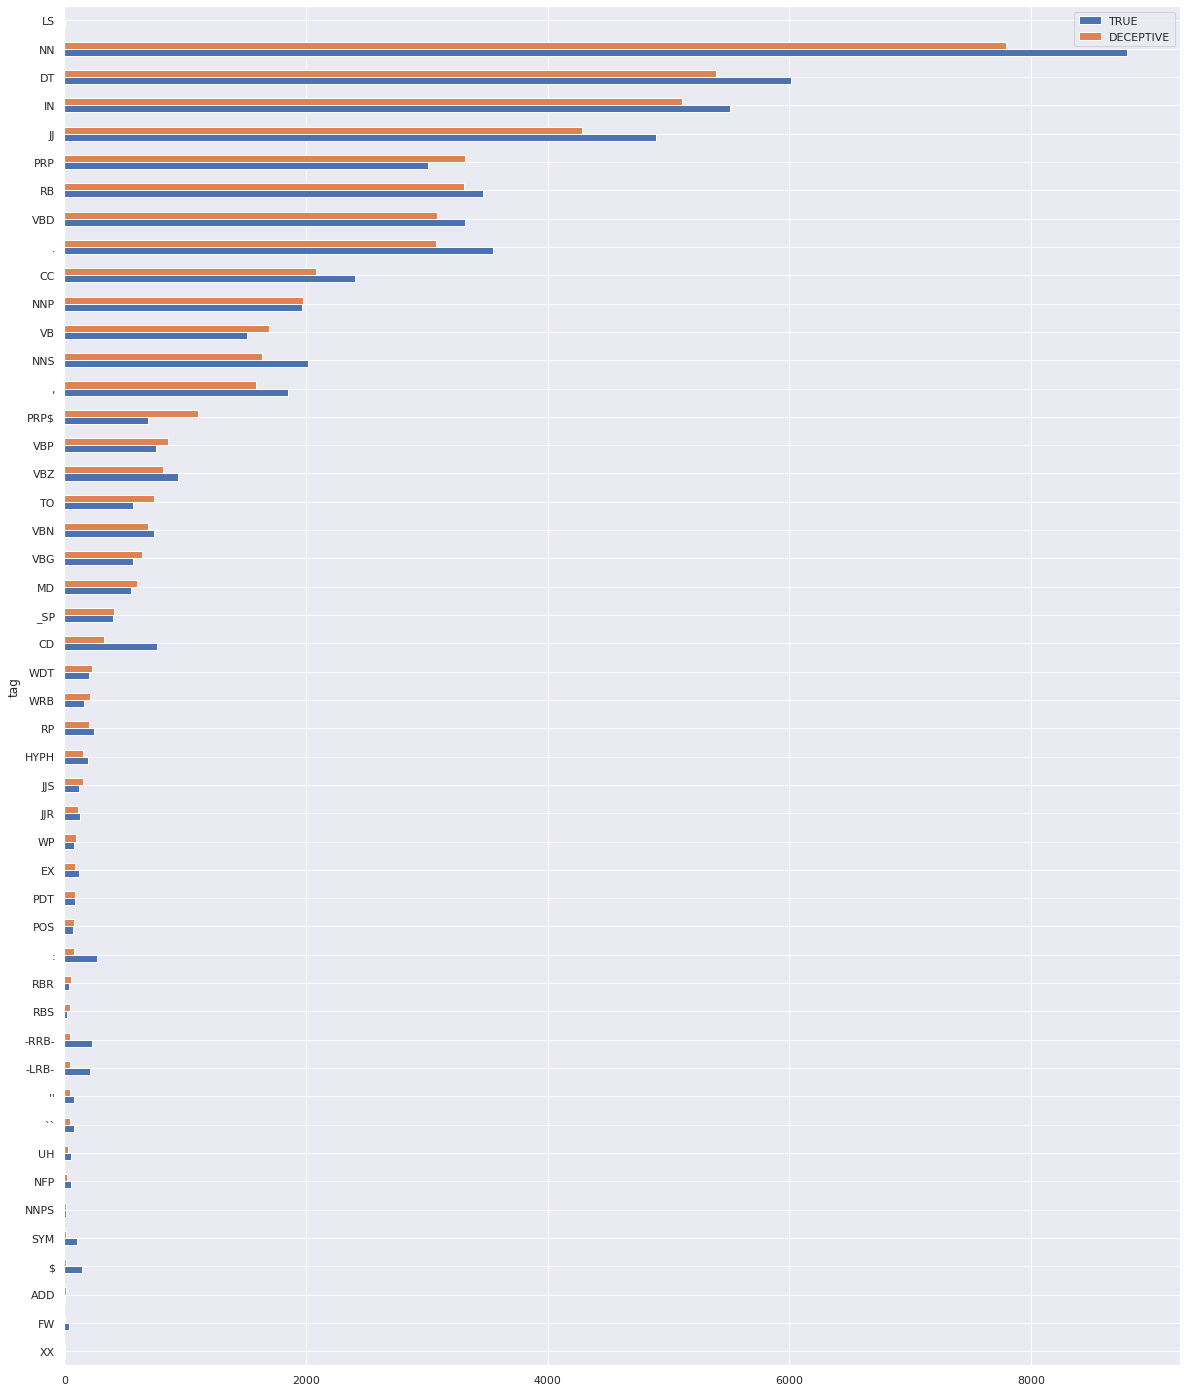

In [28]:
fig, ax = plt.subplots(figsize=(20, 25))
pos_tag_count(df[df.polarity == 'positive']).sort_values(by=['dec_cnt']).plot(kind= 'barh', rot=0, ax=ax);
ax.legend(['TRUE', 'DECEPTIVE']);



Observations in Positive Reviews:

Personal Pronoun (PRP)

    I, he, she, it

The count of PRP(Personal pronoun) is higher is Deceptive compared to the true Reviews.

Possesive Pronoun (PRP$)

    my, his, her

The count of PRP$(Possesive Pronoun) is higher is Deceptive compared to the true Reviews.

Verb, non-3rd person singular present (VBP)

    am, are

The count of VBP(Verb, non-3rd person singular present) is higher is Deceptive compared to the true Reviews.



### POS Tags counts in Negative Reviews¶

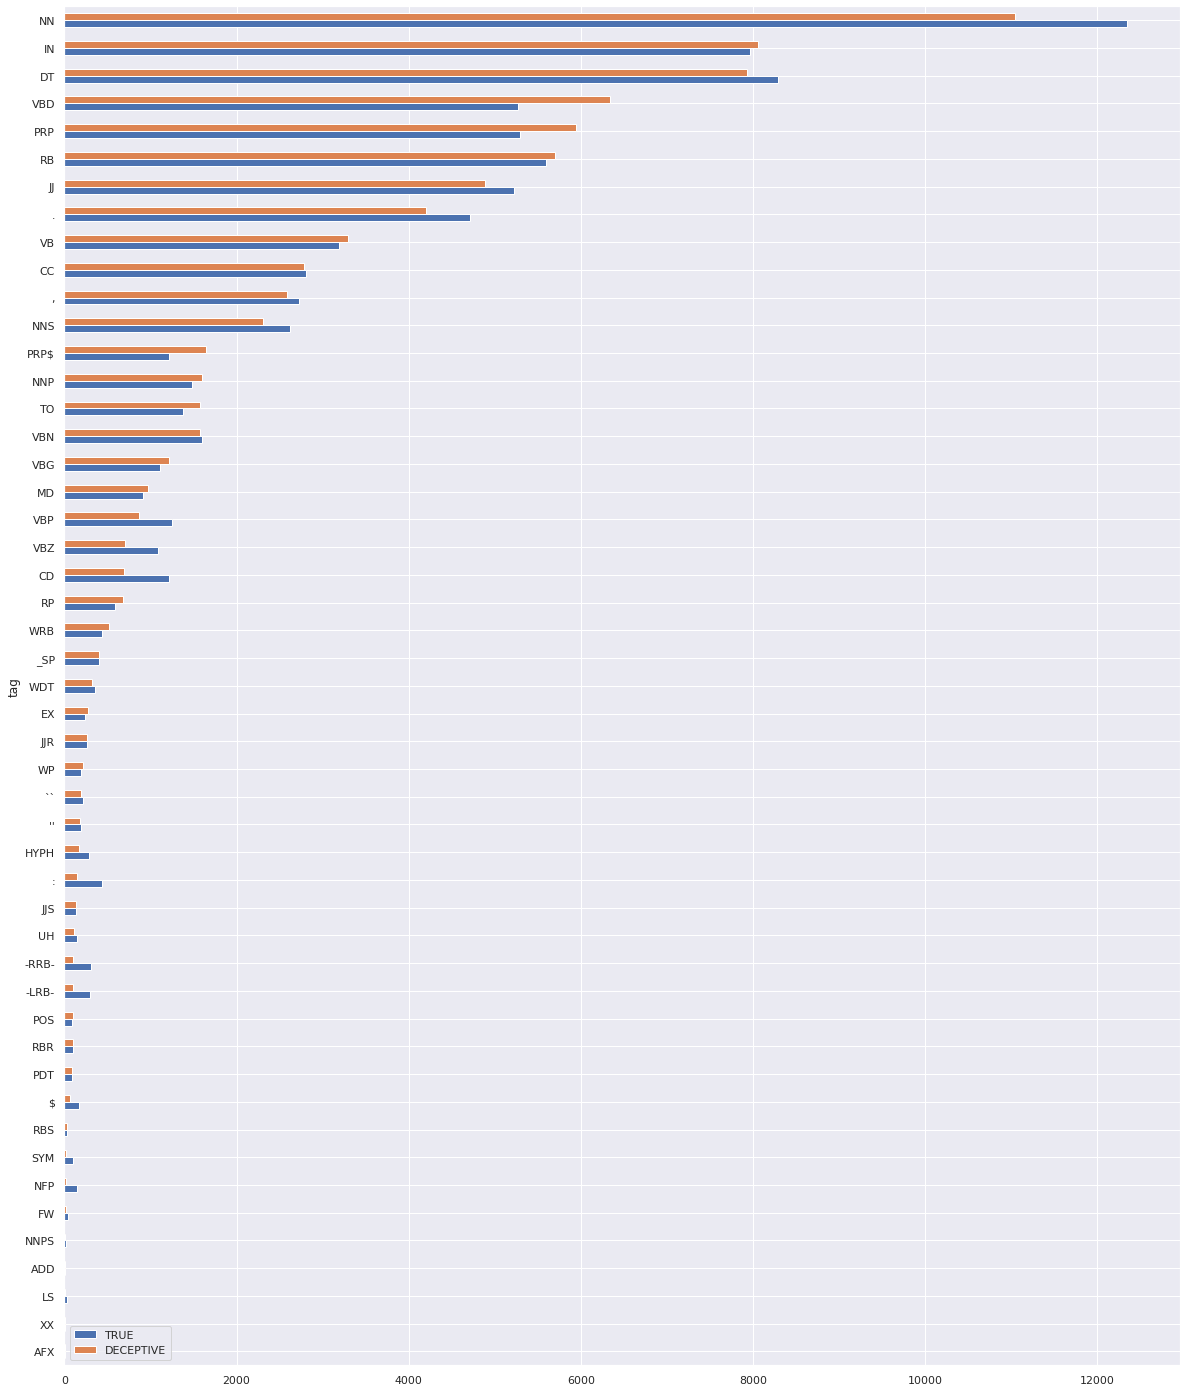

In [32]:
fig, ax = plt.subplots(figsize=(20, 25))
pos_tag_count(df[df.polarity == 'negative']).sort_values(by=['dec_cnt']).plot(kind= 'barh', rot=0, ax=ax);
ax.legend(['TRUE', 'DECEPTIVE']);

Observations in Negative Reviews:

Personal Pronoun (PRP)

    I, he, she, it

The count of PRP(Personal pronoun) is higher is Deceptive compared to the true Reviews.

Possesive Pronoun (PRP$)

    my, his

The count of PRP$(Possesive Pronoun) is higher is Deceptive compared to the true Reviews.

Verb, past tense (VBD)

    was, were

The count of VBD(Verb, past tense) is higher is Deceptive compared to the true Reviews.

### POS Tags Combining Positive and Negative Sentiments¶

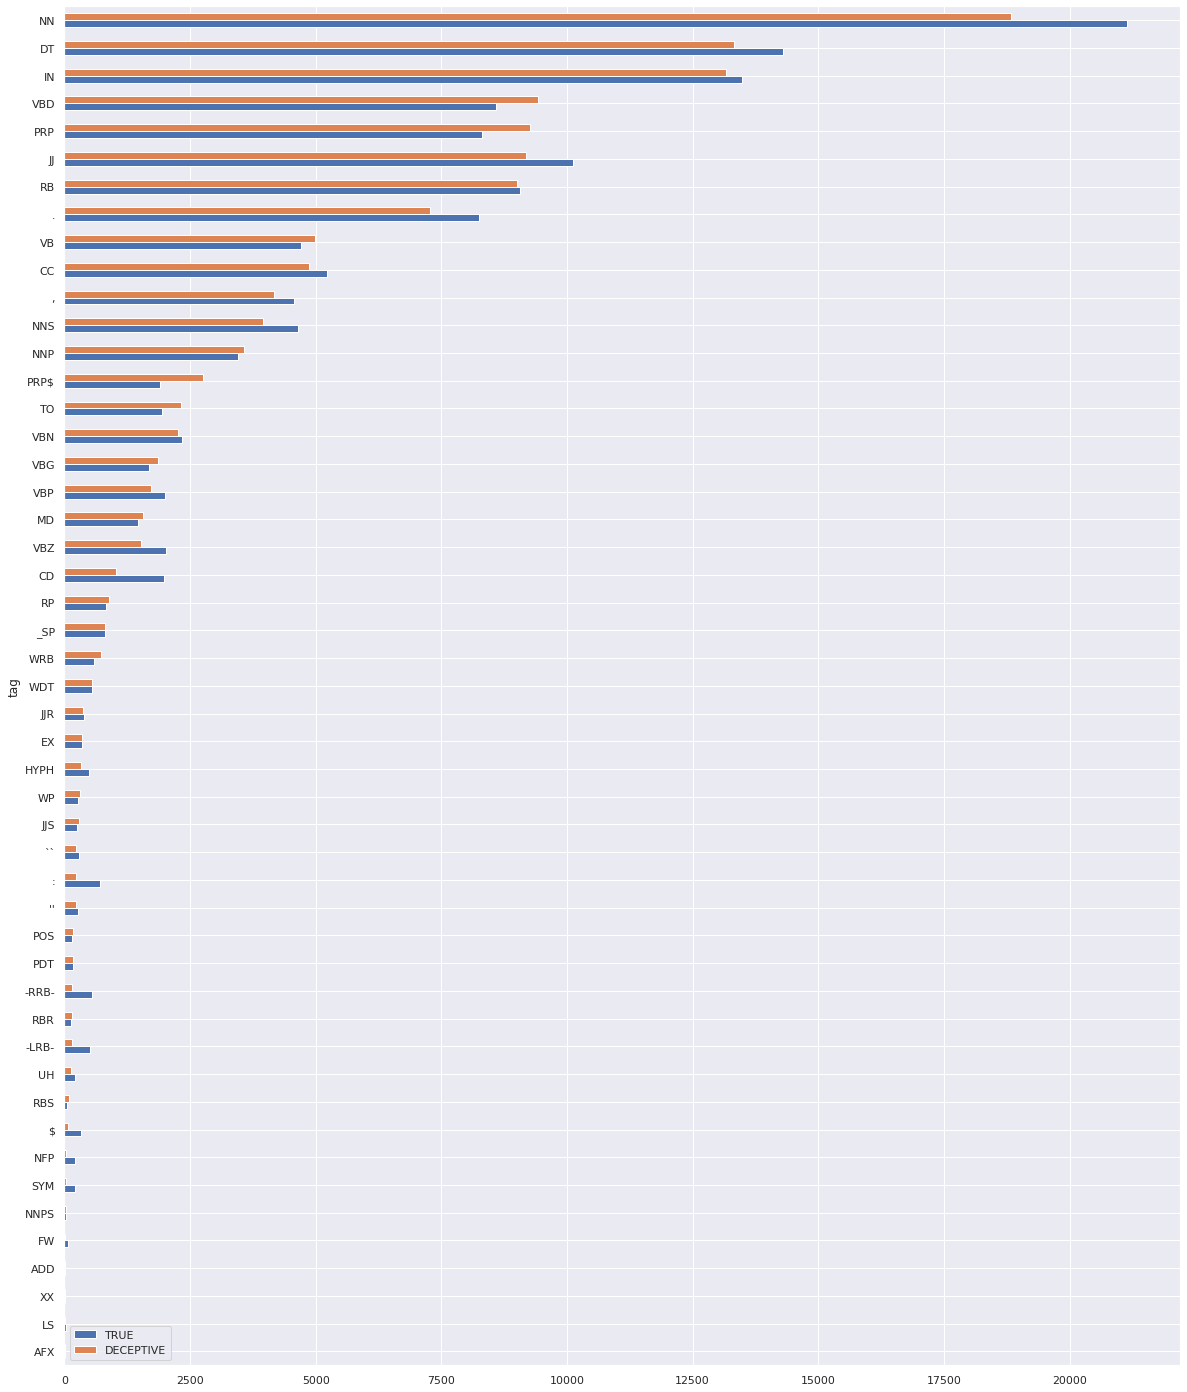

In [35]:
fig, ax = plt.subplots(figsize=(20, 25))
pos_tag_count(df).sort_values(by=['dec_cnt']).plot(kind= 'barh', rot=0, ax=ax);
ax.legend(['TRUE', 'DECEPTIVE']);

Observations in Combined Positive and Negative Reviews:

Personal Pronoun (PRP)

    I, he,she, it

The count of PRP(Personal pronoun) is higher is Deceptive compared to the true Reviews.

Possesive Pronoun (PRP$)

    my, his, her

The count of PRP$(Possesive Pronoun) is higher is Deceptive compared to the true Reviews.

## Converting Text into Machine Interpretable Numbers¶

In [40]:
X= df.review
y = df.label

def preprocess(text):
    
    # Lower the Text
    text= text.lower()
    
    # Passing the text into SpaCy Document Object
    doc= pipeline(text)
    
    # Extracting tokens out of SpaCy Document Object
    tokens= [str(t) for t in doc]
    
    # Removing the Punctuation
    tokens= [word.translate(str.maketrans('', '', string.punctuation)) for word in tokens]
    
    # remove words that contain numbers
    tokens = [word for word in tokens if not any(c.isdigit() for c in word)]
    
    # remove empty tokens
    tokens = [t for t in tokens if len(t) > 0]
    
    return tokens

#### Filtering POS Tags


In [45]:
import nltk

In [46]:
# Allowed POS Tags
allowed_word_types = ["PRP", "JJ", "NNP", "NNS", "PRP$", "VBD", "VB"]

all_words = []
for p in X:
    # Preprocessing the text
    words = preprocess(p)
    # Getting the POS tags using NLTK pos_tags function
    pos = nltk.pos_tag(words)
    for w in pos:
        ### w is a tuple and second element is POS Tag 
        if w[1] in allowed_word_types:
            ## W[0] is the word
            all_words.append(str(w[0]))        
            
pos_word_final = list(set(all_words))

In [47]:
#Feature Selection


# from sklearn.feature_selection import SelectPercentile, chi2
# X_new = SelectPercentile(chi2, percentile=10).fit_transform(x, y)


In [ ]:
import gensim

google_word2vec = gensim.models.KeyedVectors\
            .load_word2vec_format('/home/cepheus/WordEmbeddings/GoogleNews-vectors-negative300(1).bin.gz',
                                  binary=True)

In [ ]:
google_word2vec['hello'].shape

In [ ]:
def get_mean_vector(words):
    # remove out-of-vocabulary words
    words = [word for word in words if word in google_word2vec.vocab]
    if len(words) >= 1:
        return np.mean(google_word2vec[words], axis=0)
    else:
        return []
    
x = df.spacy.apply(lambda x: get_mean_vector([str(word) for word in x]))

In [ ]:
x = x.spacy.apply(pd.Series)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, 
                                                    random_state=40)


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.5,
              learning_rate=0.02, max_delta_step=0, max_depth=5,
              min_child_weight=5, missing=None, n_estimators=600, n_jobs=1,
              nthread=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.6, verbosity=1)
xgb.fit(X_train, y_train)

In [ ]:
y_pred= xgb.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

print("Training Set Accuracy: ", accuracy_score(y_train, lr.predict(X_train)))
print("Test Set Accuracy: ", accuracy_score(y_test, y_pred))

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

## End Result 

In [ ]:
class deceptive:
    def __init__(self, text):
        self.test= nlp(text)
        
    def get_mean_vector(self, words):
        # remove out-of-vocabulary words
        words = [word for word in words if word in google_word2vec.vocab]
        if len(words) >= 1:
            return np.mean(google_word2vec[words], axis=0)
        else:
            return []
        
    def predict(self):
        self.test= [str(t) for t in self.test]
        self.vectors= self.get_mean_vector(self.test)
        return xgb.predict(pd.DataFrame([self.vectors]))[0]

In [ ]:
deceptive(X[0]).predict()